# *Monod* fit to mESC under DMSO and IdU conditions

In this notebook, we analyze two 10x v2 datasets accompanying the article "A DNA repair pathway can regulate transcriptional
noise to promote cell fate transitions" by Desai et al. (2021). The authors argue, based on 10x moments and fluorescence model fits, that IdU perturbation modulates gene noise without substantially changing the mean. We analyze the dataset with an eye to producing model fits to the 10x data.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/hom

In [21]:
dataset_meta = ['desai_dmso','desai_idu']
dataset_names = dataset_meta 
raw_data_locations = dataset_meta

transcriptome_filepath = '../monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


loom_filepaths = ['/home/ggorin/count_data/loom_desai_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)

In [3]:
loom_filepaths

['/home/ggorin/count_data/loom_desai_kb/desai_dmso.loom',
 '/home/ggorin/count_data/loom_desai_kb/desai_idu.loom']

In [4]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [5]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

Do some light knee plot filtering.

/home/ggorin/count_data/loom_desai_kb/desai_dmso.loom
Dataset desai_dmso. 
	904 barcodes in loom, 831 pass filter.
/home/ggorin/count_data/loom_desai_kb/desai_idu.loom
Dataset desai_idu. 
	805 barcodes in loom, 766 pass filter.


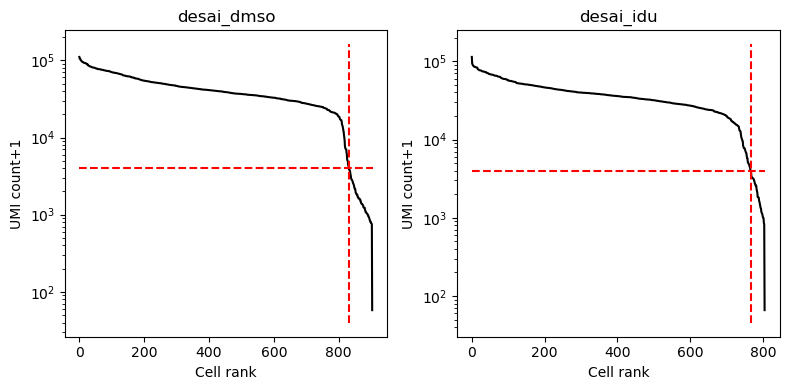

In [7]:
cf = []
thr_lb = [4e3, 4e3]
S_arr = []
U_arr = []


fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = dataset_meta[k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        ax1[k].set_title(dataset_meta[k])        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')

        S_arr.append(S)
        U_arr.append(U)
        cf.append(cf_)
fig1.tight_layout()
plt.savefig('figs/kneeplots_desai.png',dpi=450)

In [8]:
[x.sum() for x in cf]

[831, 766]

## DMSO/IdU comparison

Examine moments. The means and variances look quite similar by eye.

In [9]:
def plot_stat(X,Y,stat,ax1,modality='spliced',plot_offset=False,log=True):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='var':
        stat_fun = lambda x: (x.var(1))
    elif stat=='Fano':
        stat_fun = lambda x: (x.var(1))/(x.mean(1))
    elif stat=='Fanop1':
        stat_fun = lambda x: (x.var(1))/(x.mean(1))+1
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    if plot_offset:
        offset = y.mean()/x.mean()
        print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='lightseagreen',linewidth=2)
    if log:
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    ax1.set_xlabel('dmso {} {}'.format(stat,modality))
    ax1.set_ylabel('idu {} {}'.format(stat,modality))

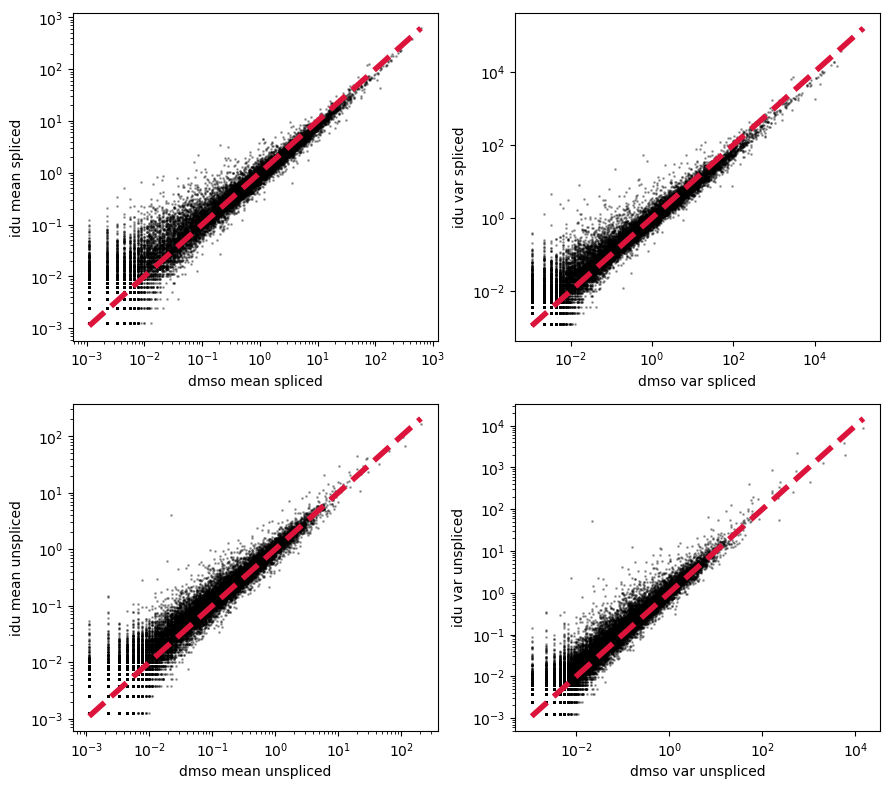

In [10]:
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(S_arr[0],S_arr[1],'mean',ax1[0][0],'spliced')
plot_stat(S_arr[0],S_arr[1],'var',ax1[0][1],'spliced')
plot_stat(U_arr[0],U_arr[1],'mean',ax1[1][0],'unspliced')
plot_stat(U_arr[0],U_arr[1],'var',ax1[1][1],'unspliced')
fig1.tight_layout()


/tmp/ipykernel_3305569/680583236.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)


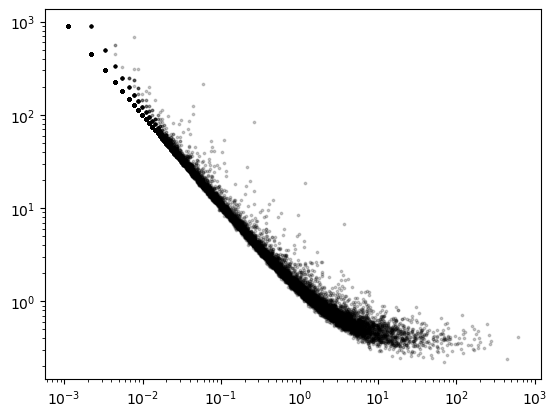

In [11]:
plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_3305569/2533449854.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)


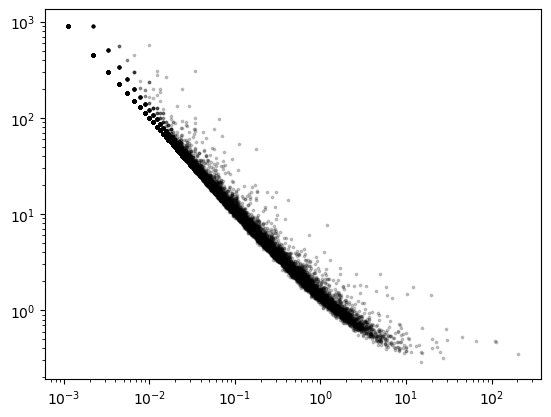

In [12]:
plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

## Preprocessing

Identify the genes to fit.

Construct a batch by finding 2,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [13]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [22]:
transcriptome_filepath

'../monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

Ensure genes of interest are fit.

In [15]:
markers = ['Nanog','Sox2', 'Pou5f1','Klf4','Wdr83','Stx7','Hif1an','Mtpap','Farsa','Wipi2','Snd1']

In [16]:
[x in gene_names for x in markers]

[True, True, True, True, True, True, True, True, True, True, True]

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_240821_029_desai_1 created.
INFO:root:Dataset: desai_dmso
INFO:root:831 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31929 were unique.
INFO:root:3836 genes retained after expression filter.
INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_dmso created.
INFO:root:Dataset: desai_idu
INFO:root:766 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31929 were unique.
INFO:root:4373 genes retained after expression filter.
INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_idu created.
INFO:root:Total of 2000 genes selected.
INFO:root:Directory ./fits/gg_240821_029_desai_1/diagnostic_figures created.


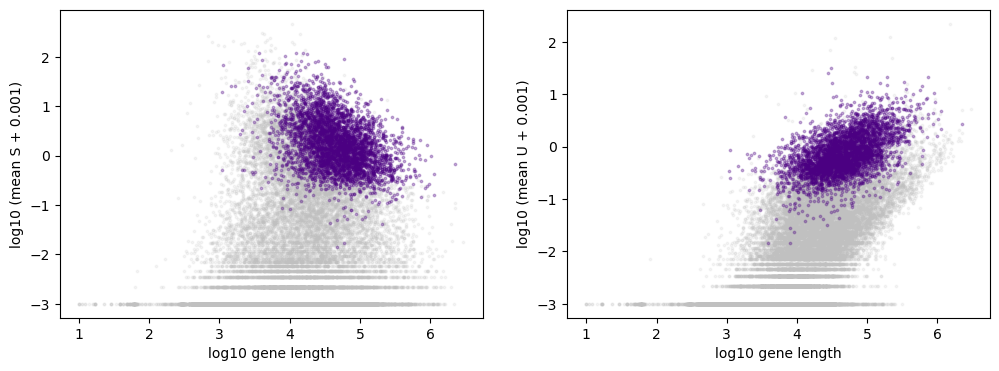

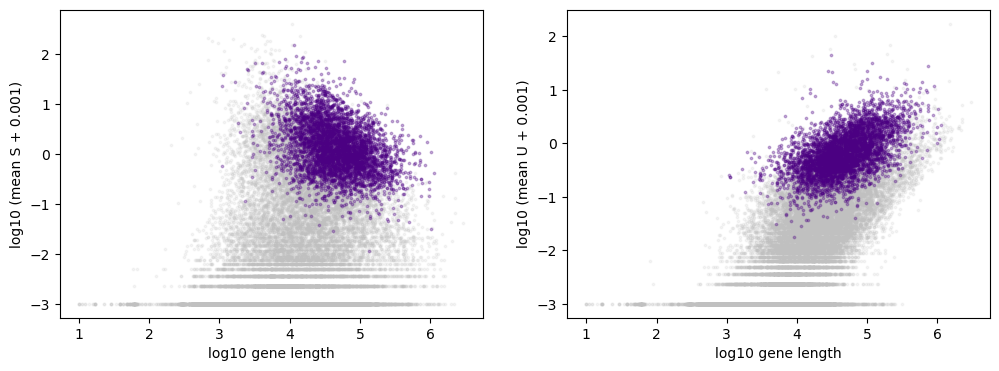

In [24]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='desai',batch_id=1,\
                                             n_genes=2000,exp_filter_threshold=None,cf=cf,genes_to_fit=markers)

## Inference

In [25]:
dir_string

'./fits/gg_240821_029_desai_1'

In [26]:
dataset_strings

['./fits/gg_240821_029_desai_1/desai_dmso',
 './fits/gg_240821_029_desai_1/desai_idu']

Define parameter bounds, then iterate over datasets and perform the fits.

In [27]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-7.5, -2]
samp_ub = [-5.5, 0]
gridsize = [20,21]


gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1}

INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: desai_dmso
INFO:root:32285 features observed, 32005 match genome annotations. 31929 were unique.
INFO:root:Gene list extracted from ./fits/gg_240821_029_desai_1/genes.csv.
INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_dmso/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_240821_029_desai_1/desai_dmso/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████| 420/420 [17:03<00:00,  2.44s/it]  /home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 1025.5 seconds.
INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: desai_idu
INFO:root:32285 features observed, 32005 match genome annotations. 31929 were unique.
INFO:root:Gene list extracted from ./fits/gg_240821_029_desai_1/genes.csv.
INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_idu/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_240821_029_desai_1/desai_idu/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████| 420/420 [16:29<00:00,  2.36s/it]  /home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 991.8 seconds.


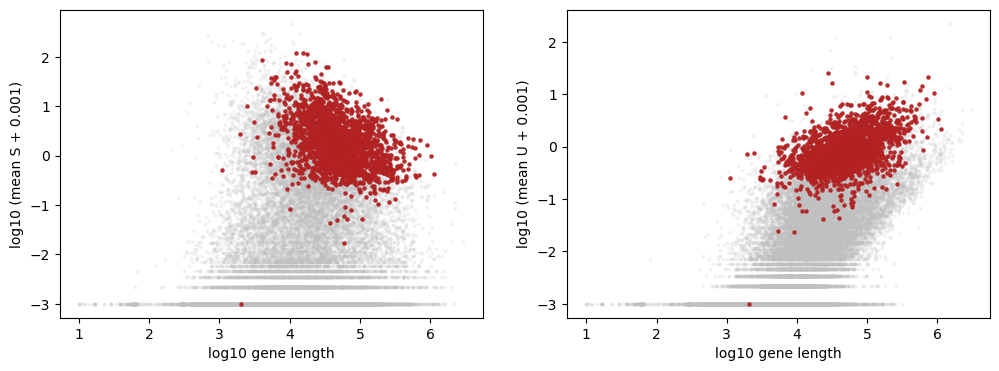

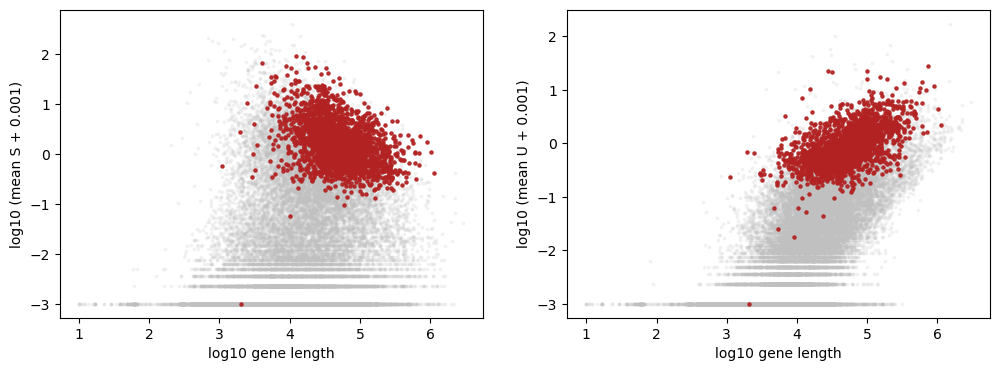

In [28]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(80,search_data)
    result_strings.append(full_result_string)

In [ ]:
dir_string

'./fits/gg_240821_029_desai_1'

In [ ]:
dataset_strings

['./fits/gg_240821_029_desai_1/desai_dmso',
 './fits/gg_240821_029_desai_1/desai_idu']

In [ ]:
result_strings

['./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/grid_scan_results.res']

## Post-processing

Identify sampling parameter optima, though as discussed in "Length Biases...", this problem is typically difficult to impossible for v2 data.

INFO:root:Grid scan results loaded from ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_240821_029_desai_1/desai_dmso/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 193 genes out of 2000. Runtime: 5.2 seconds.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -7.18, -1.00.
INFO:root:Chi-square computation complete. Rejected 193 genes out of 2000. Runtime: 5.1 seconds.

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen

INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 1184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 33.6 seconds.


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_240821_029_desai_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_240821_029_desai_1/desai_idu/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 209 genes out of 2000. Runtime: 4.9 seconds.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_i

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8c629040>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6b8dec1b80>
  self.pid = os.fork()
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/popen

INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 727 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1490 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 39.9 seconds.


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_240821_029_desai_1/analysis_figures already exists.


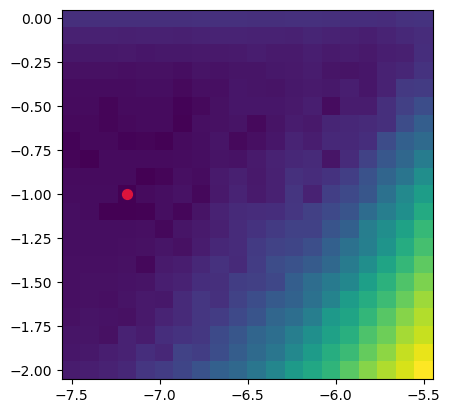

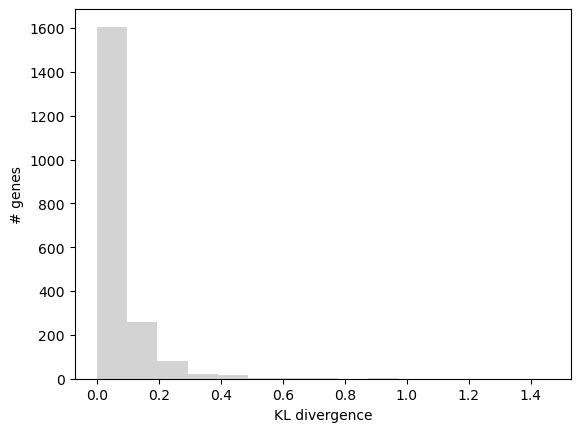

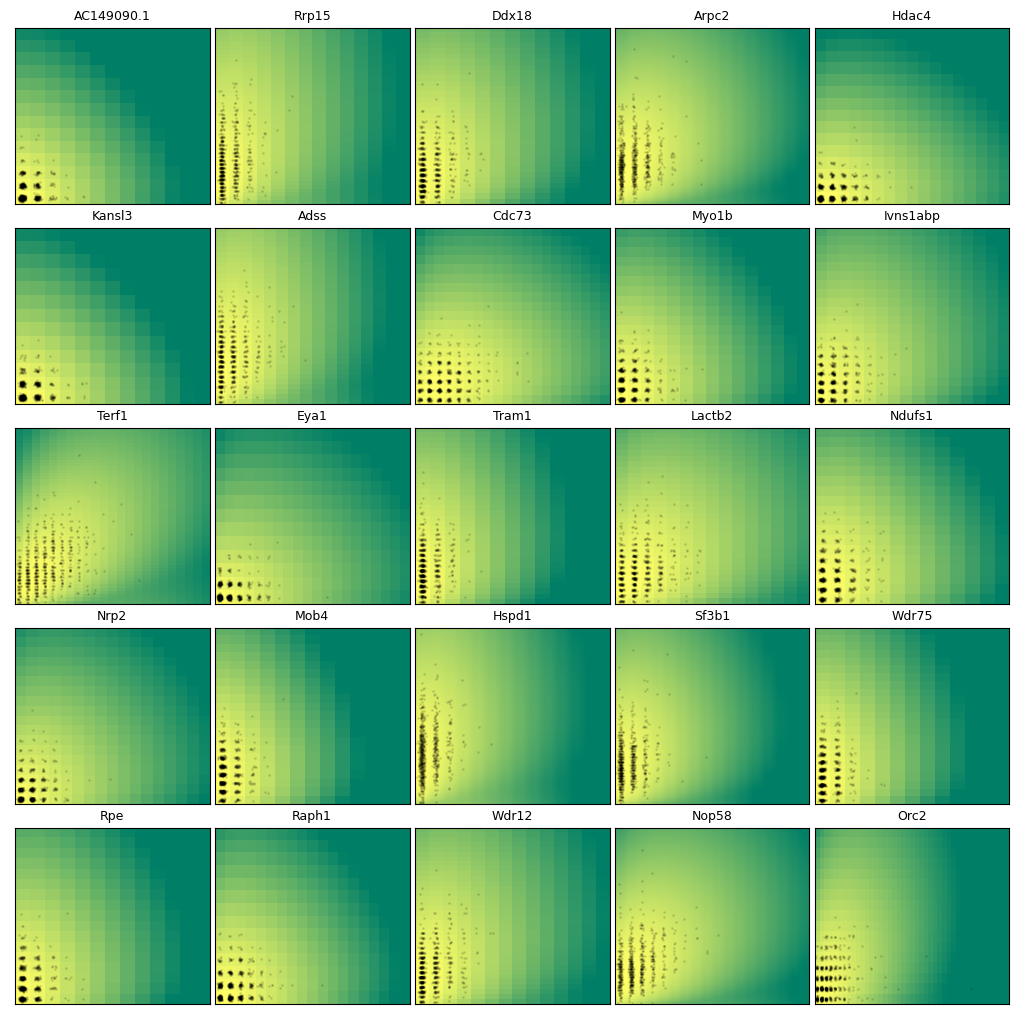

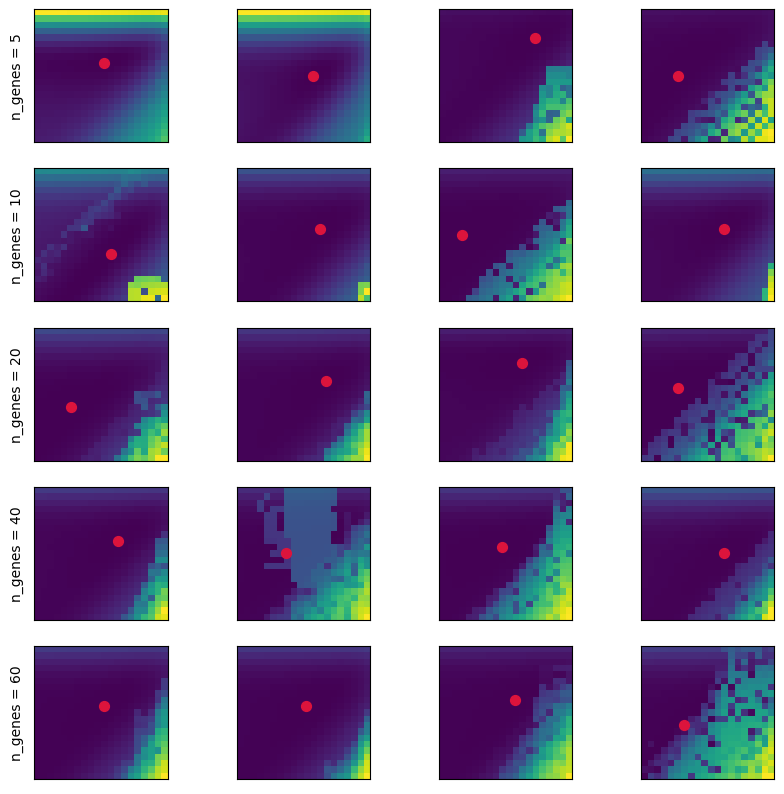

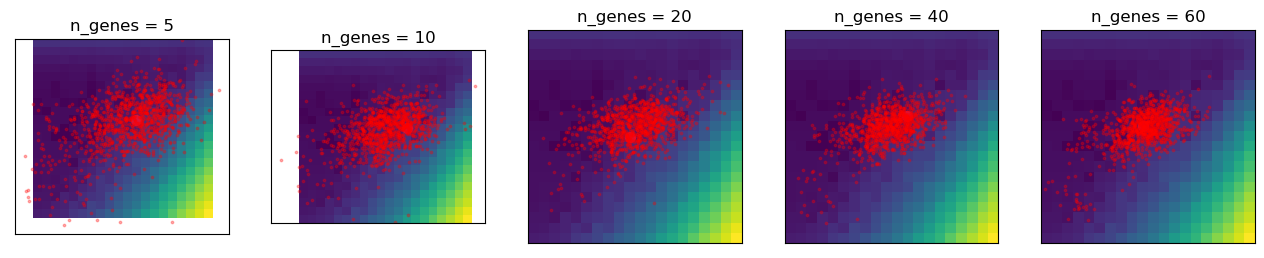

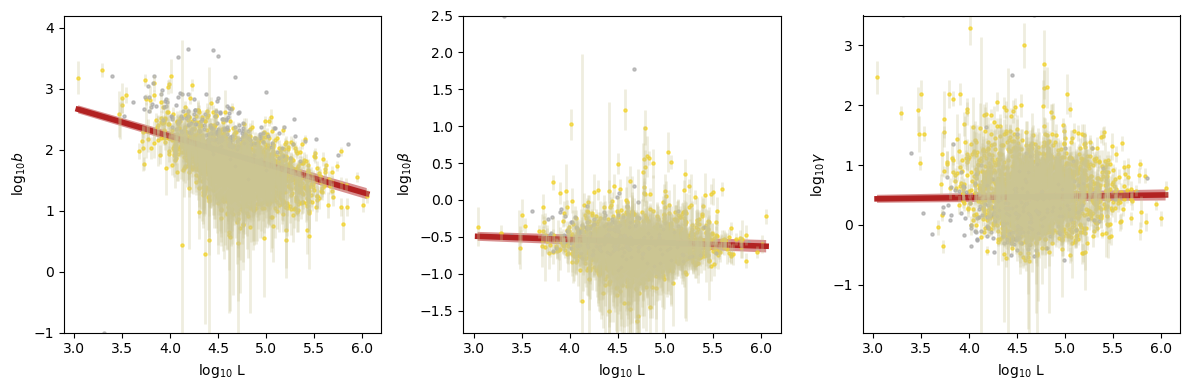

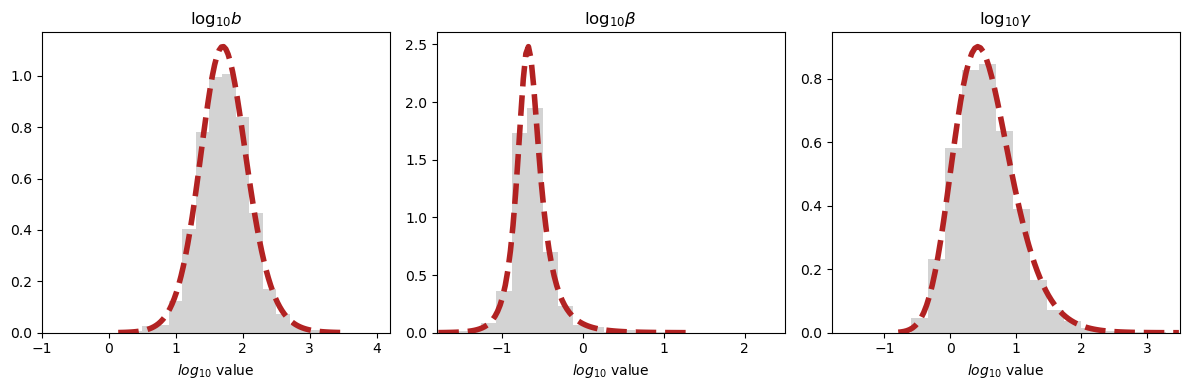

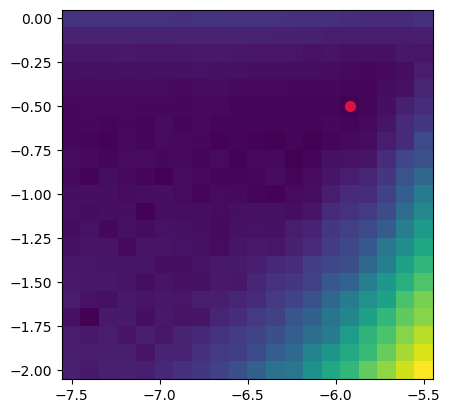

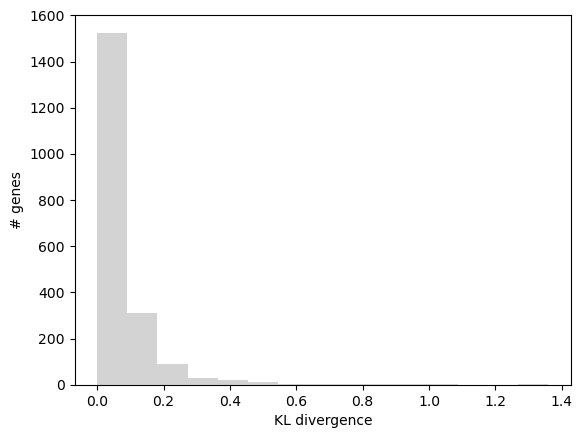

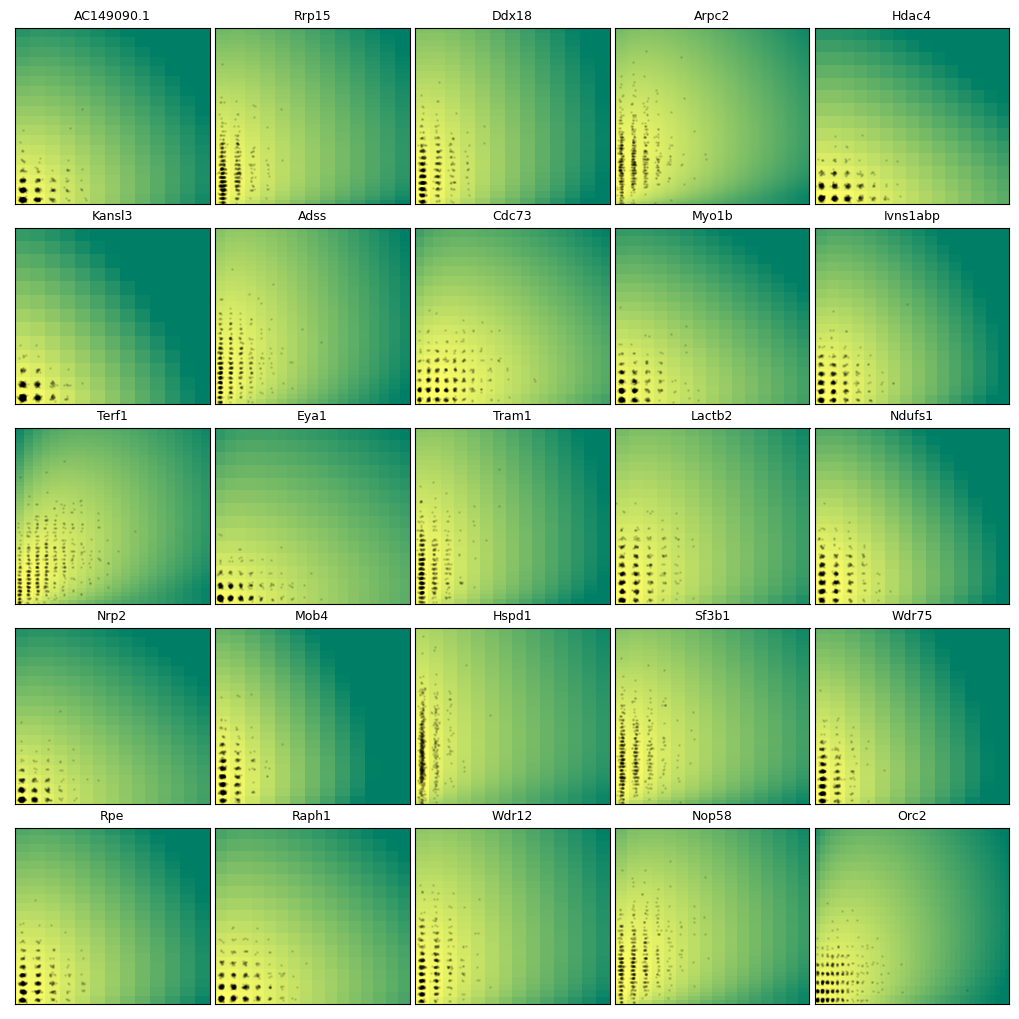

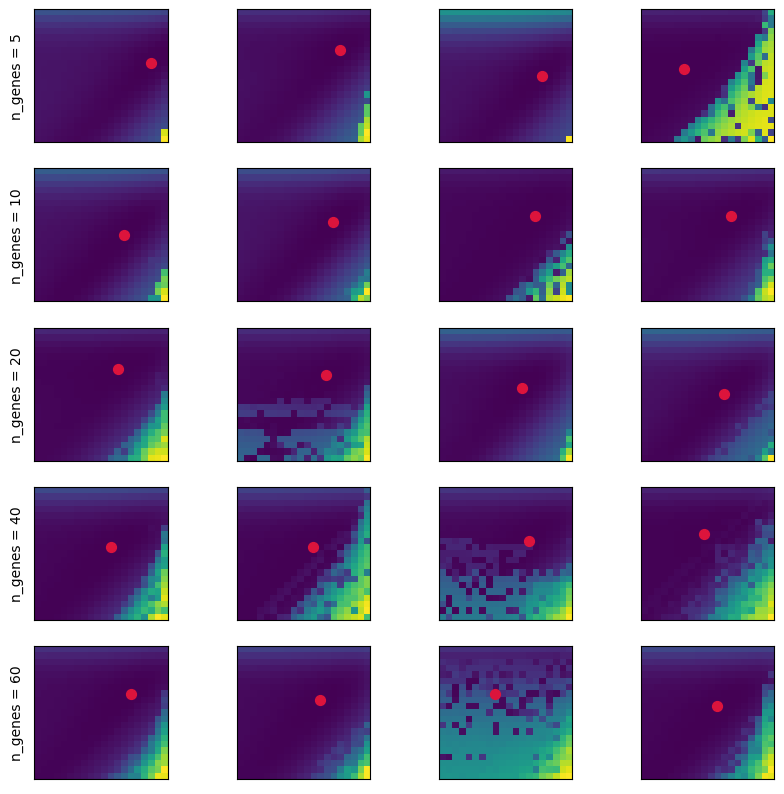

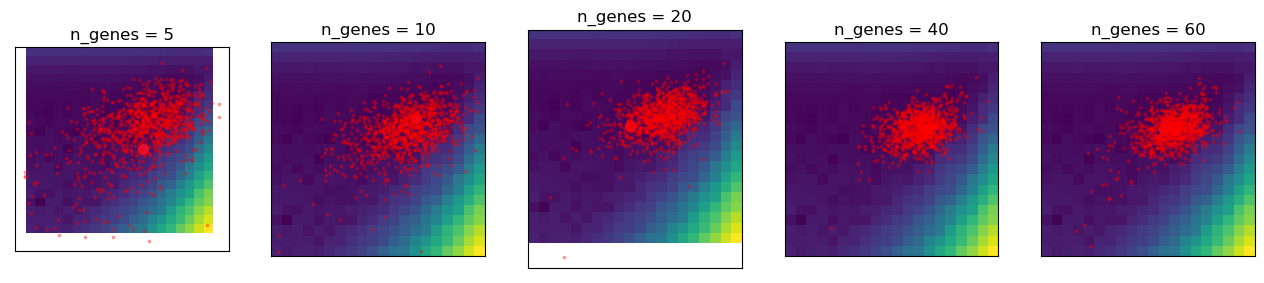

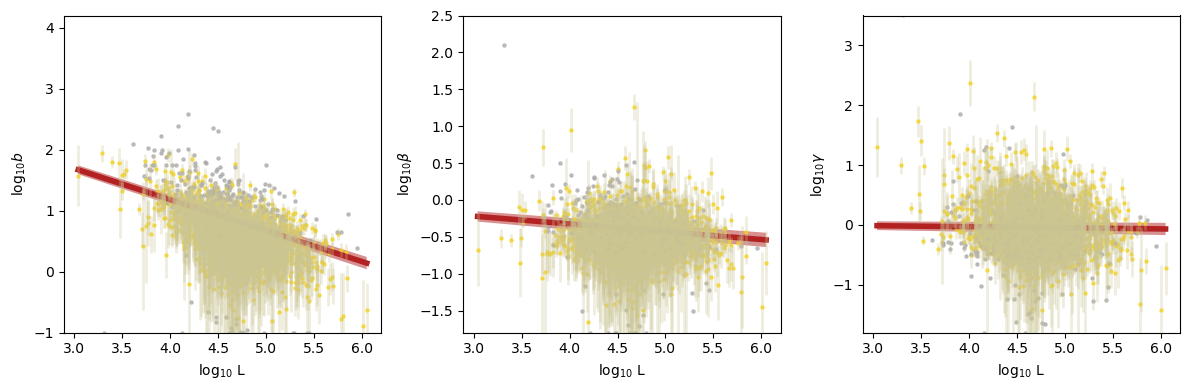

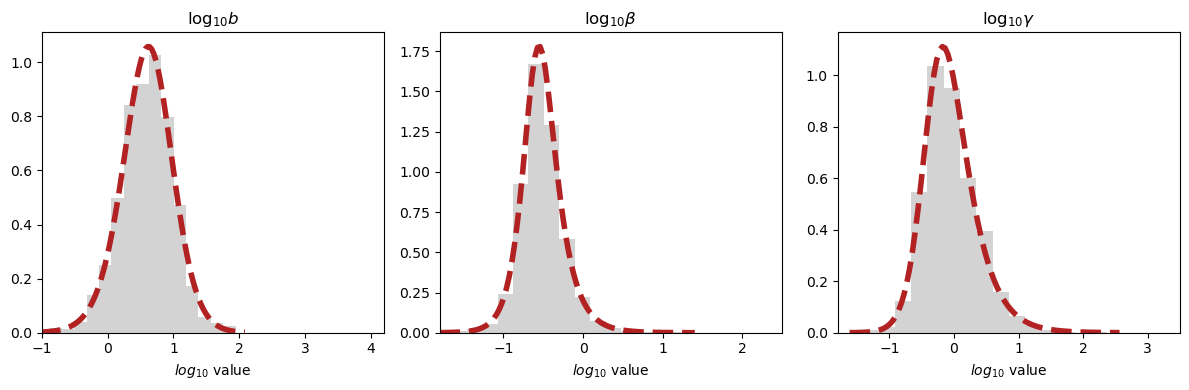

In [ ]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(+result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
#     if i==0:
    sr.find_sampling_optimum()
#     else:
#         sr.set_sampling_optimum(samp_ind)
#         samp_ind = sr.sampl
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    samp_ind = sr.samp_optimum_ind
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [39]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()
    print(sr.samp_optimum)
    print(sr.phys_optimum[:10])

INFO:root:Grid scan results loaded from ./fits/gg_240821_029_desai_1/desai_dmso/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_240821_029_desai_1/desai_dmso/raw.sd.
(-7.184210526315789, -1.0)
[[ 2.15793336 -0.68180018  1.44068279]
 [ 2.00569288 -0.4070552  -0.00532621]
 [ 2.12180664 -0.59482568  0.36295541]
 [ 2.01287779 -0.61105354 -0.2278216 ]
 [ 1.20818782 -0.57645148  0.44504002]
 [ 1.46943998 -0.84705604  0.80054705]
 [ 1.88668137 -0.64043991 -0.05857676]
 [ 1.68430257 -0.85833247  0.40108146]
 [ 1.13458391 -0.63592503 -0.05621773]
 [ 2.30655403 -0.50437662  1.02145967]]
INFO:root:Grid scan results loaded from ./fits/gg_240821_029_desai_1/desai_idu/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_240821_029_desai_1/desai_idu/raw.sd.
(-5.921052631578947, -0.5)
[[ 1.32376287 -0.39081748  0.93357642]
 [ 0.95453603 -0.1201917  -0.37214497]
 [ 1.01842203 -0.34616894 -0.10989442]
 [ 1.18852182 -0.23049997 -0

In [41]:
pd.read_csv("./fits/gg_240821_029_desai_1/genes.csv")

,AC149090.1,Rrp15,Ddx18,Arpc2,Hdac4,Kansl3,Adss,Cdc73,Myo1b,Ivns1abp,...,Utp14a,Kdm5c,Eif1ax,Tbl1x,Usp9x,Taf1,Renbp,Chic1,Eif2s3y,Gm47283
